# Implementando uma Deep Learning do Zero em Python

In [1]:
import numpy as nb
import torch
import torch.nn.functional as F
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from time import time

In [2]:
import torch
from torchvision import datasets, transforms

# definindo a conversão de imagem para tensor
transform = transforms.ToTensor()

# Carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Cria um buffer para pegar os dados por partes

# Carrega a parte de validação (teste) do dataset
valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)  # Cria um buffer para pegar os dados por partes

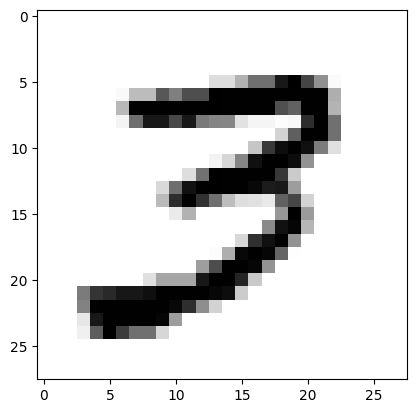

In [3]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter._next_data()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)    # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)     # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X)         # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda


In [5]:
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 10 # numero de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para o modelo
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
            perda_instantanea.backward() # calculando os gradientes
            otimizador.step() # atualizando os pesos
            perda_acumulada += perda_instantanea.item() # acumulando a perda

        else:
            print(f"Epoch {epoch+1}/{EPOCHS} - Perda acumulada: {perda_acumulada/len(trainloader):.4f}")
    
    print("\nTempo de treino (em minutos = )", (time()-inicio)/60)


In [6]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logaritmica

            ps = torch.exp(logps) # converte output para escala normal (lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


In [11]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando:", device)
modelo.to(device)


Usando: cpu


Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

### Treinar o modelo

In [8]:
treino(modelo, trainloader, device)

Epoch 1/10 - Perda acumulada: 1.1893
Epoch 2/10 - Perda acumulada: 0.3893
Epoch 3/10 - Perda acumulada: 0.3188
Epoch 4/10 - Perda acumulada: 0.2767
Epoch 5/10 - Perda acumulada: 0.2440
Epoch 6/10 - Perda acumulada: 0.2180
Epoch 7/10 - Perda acumulada: 0.1965
Epoch 8/10 - Perda acumulada: 0.1784
Epoch 9/10 - Perda acumulada: 0.1623
Epoch 10/10 - Perda acumulada: 0.1490

Tempo de treino (em minutos = ) 0.7380694667498271


### Validar/Testar o modelo

In [9]:
validacao(modelo, valloader, device)


Total de imagens testadas = 10000

Precisão do modelo = 95.77%


### Testar em uma única imagem

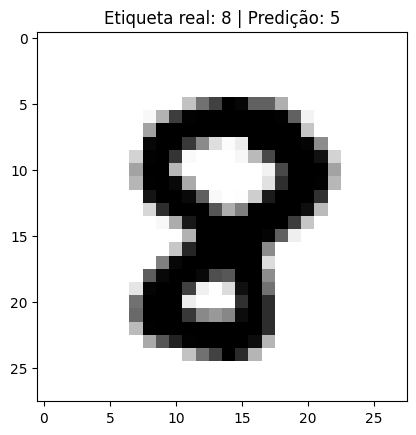

In [16]:
import matplotlib.pyplot as plt

# pegar uma amostra
dataiter = iter(valloader)
imagens, etiquetas = next(dataiter)

# escolher a primeira imagem
img = imagens[0].view(1, 784)

with torch.no_grad():
    logps = modelo(img.to(device))

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
etiqueta_pred = probab.index(max(probab))

plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Etiqueta real: {etiquetas[0].item()} | Predição: {etiqueta_pred}")
plt.show()
